# 1. Data and Pre-processing

## 1.1 Libraries

In [1]:
import os
import gc
import cv2
import json
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import dump, load
import matplotlib.pyplot as plt
from collections import defaultdict
from timeit import default_timer as timer 
from going_modular.going_modular import utils, engine

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import torch
import torchviz
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torchsummary import summary as torchsummary
from torch.nn import functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, BatchSampler

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from torchmetrics.classification import MulticlassAUROC


In [4]:
print(torch.__version__)
print(torch.cuda.get_device_name())

2.0.1+cu118
NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 1.2.1 Data Set class examples

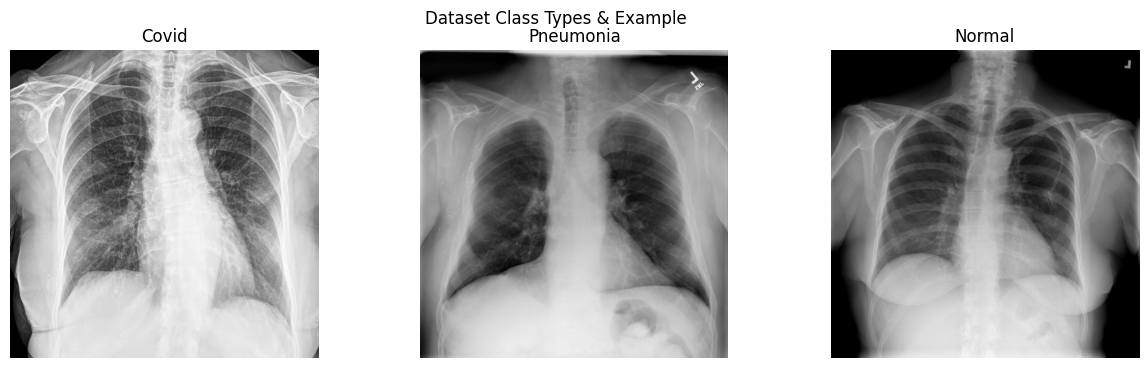

In [6]:
img1 = [f"data/train/covid/COVID-19 (2).png", 
        f"data/train/pneumonia/00000165_001.png",
        f"data/train/normal/00000005_003.png"]

fig = plt.figure(figsize = (15,4))

for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(Image.open(img1[i]).convert('RGB'))
    plt.axis('off')

plt.subplot(1,3,1)
plt.title("Covid")

plt.subplot(1,3,2)
plt.title("Pneumonia")

plt.subplot(1,3,3)
plt.title("Normal")

plt.suptitle("Dataset Class Types & Example")
plt.show()

## 1.2.2 Dataset Loading

In [7]:
target_size = (224, 224)
batch_size = 20

In [8]:
def idx_to_label(id):
    labels = {0: 'covid', 1: 'normal', 2: 'pneumonia'}
    return labels[id]

def label_to_idx(label):
    idx = {'covid': 0, 'normal': 1, 'pneumonia': 2}
    return idx[label]

def idx_to_onehot(idx):
    onehot = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
    return onehot[idx]

In [9]:
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [10]:
# Load the datasets
trainset = datasets.ImageFolder('data/train', 
                                transform=transform) 

valset = datasets.ImageFolder('data/val',
                                transform=transform) 

testset = datasets.ImageFolder('data/test', 
                               transform=transform) 

In [11]:
# Create data loaders 
train_loader = DataLoader(trainset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

val_loader = DataLoader(valset, 
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)


test_loader = DataLoader(testset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

In [12]:
print("Training Data:",len(train_loader)*batch_size)
print("Validation Data:",len(val_loader)*batch_size)
print("Testing Data:",len(test_loader)*batch_size)

Training Data: 9000
Validation Data: 540
Testing Data: 300


# 2. CNN Model

In [13]:
class MobileNetV2Custom(nn.Module):
    def __init__(self):
        super(MobileNetV2Custom, self).__init__()
        
        # Get pretrained MobileNetV2 
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Get the features module
        self.features = self.mobilenet.features
        
        # Update the classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.2),
            nn.Linear(62720, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    
    def forward(self, x):
        x = self.features(x)

        # Flatten the features for classification
        x = torch.flatten(x, 1)

        # Classifier
        x = self.classifier(x)
        return x


In [14]:
# Set the random seeds
torch.manual_seed(101)
torch.cuda.manual_seed(101)

In [15]:
grid_model = NeuralNetClassifier(
    module=MobileNetV2Custom()
)

print(grid_model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MobileNetV2Custom(
    (mobilenet): MobileNetV2(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedRes

In [16]:
param_grid = {
    'optimizer__lr': [0.001, 0.01, 0.1],
    'optimizer': [optim.SGD, optim.RMSprop, optim.Adam, optim.Adadelta],
}

In [17]:
grid_len = int(len(train_loader)/2)

In [34]:
images = None
labels = None
for i in tqdm(range(grid_len)):
    images, labels = next(iter(train_loader))

100%|██████████| 225/225 [50:31<00:00, 13.47s/it]   


In [35]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(images, labels)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.5000           nan  1.3780
      2           nan       0.5000           nan  1.0828
      3           nan       0.7500           nan  1.0717
      4           nan       0.7500           nan  1.1677
      5           nan       0.7500           nan  1.2082
      6           nan       0.7500           nan  1.1984
      7           nan       0.7500           nan  1.1152
      8           nan       0.7500           nan  1.0082
      9           nan       0.5000           nan  0.9444
     10           nan       0.5000           nan  0.9343
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.5000           nan  0.9825
      2           nan       0.5000           nan  0.9906
      3           nan       0.5000           nan  82.6580
      4           nan       0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000215E8C7FE50>
Traceback (most recent call last):
  File "c:\Users\JASHR\anaconda3\envs\dl\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\JASHR\anaconda3\envs\dl\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2500           nan  1.1182
      2           nan       0.2500           nan  1.1271
      3           nan       0.2500           nan  1.1517
      4           nan       0.2500           nan  1.1315
      5           nan       0.2500           nan  1.0668
      6           nan       0.5000           nan  1.0970
      7           nan       0.5000           nan  1.0936
      8           nan       0.5000           nan  1.1034
      9           nan       0.5000           nan  1.0753
     10           nan       0.5000           nan  1.0908
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2500           nan  1.0494
      2           nan       0.2500           nan  1.0592
      3           nan       0.2500           nan  1.0740
      4           nan       0.2

In [38]:
type(grid_result)

sklearn.model_selection._search.GridSearchCV

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.550000 using {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.550000 (0.187083) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.1}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.001}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.01}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.1}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.01}
0.450000 (0.100000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.1}
0.450000 (0.100000) with: {'optimiz

In [29]:
mobilenet_model = MobileNetV2Custom()

for param in mobilenet_model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, mobilenet_model.parameters()),
                    lr=0.01)


summary(model=mobilenet_model, 
            input_size=(20, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
    )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2Custom (MobileNetV2Custom)         [20, 3, 224, 224]    [20, 3]              1,281,000            Partial
├─Sequential (features)                       [20, 3, 224, 224]    [20, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [20, 3, 224, 224]    [20, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [20, 3, 224, 224]    [20, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [20, 32, 112, 112]   [20, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [20, 32, 112, 112]   [20, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [20, 32, 112, 112]   [20, 16, 1

In [30]:
#Start the timer
from timeit import default_timer as timer 
start_time = timer()


# Ref: https://www.learnpytorch.io/05_pytorch_going_modular/
# Setup training and save the results
results = engine.train(model=mobilenet_model,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=criterion,
                       epochs=100,
                       device=device,
                       patience = 20)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

utils.save_model(model=mobilenet_model,
                 target_dir="models",
                 model_name="mobilenet_cnn_classifier.pth")
torch.save(results, 'Objects/mobilenet_results.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2883 | train_acc: 0.8969 | test_loss: 0.2095 | test_acc: 0.9315
Validation Loss Improved: from inf to 0.2095
Epoch: 2 | train_loss: 0.1394 | train_acc: 0.9509 | test_loss: 0.2120 | test_acc: 0.9204
Validation Loss didn't Improve, patience: 1
Epoch: 3 | train_loss: 0.0942 | train_acc: 0.9643 | test_loss: 0.1754 | test_acc: 0.9259
Validation Loss Improved: from 0.2095 to 0.1754
Epoch: 4 | train_loss: 0.0690 | train_acc: 0.9733 | test_loss: 0.1686 | test_acc: 0.9370
Validation Loss Improved: from 0.1754 to 0.1686
Epoch: 5 | train_loss: 0.0569 | train_acc: 0.9781 | test_loss: 0.1549 | test_acc: 0.9481
Validation Loss Improved: from 0.1686 to 0.1549
Epoch: 6 | train_loss: 0.0435 | train_acc: 0.9827 | test_loss: 0.2411 | test_acc: 0.9333
Validation Loss didn't Improve, patience: 1
Epoch: 7 | train_loss: 0.0312 | train_acc: 0.9891 | test_loss: 0.1248 | test_acc: 0.9537
Validation Loss Improved: from 0.1549 to 0.1248
Epoch: 8 | train_loss: 0.0285 | train_acc: 0.9896 | 

In [15]:
results = torch.load('Objects/mobilenet_results.pth')

mobilenet_model = MobileNetV2Custom().to(device)
for param in mobilenet_model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, mobilenet_model.parameters()),
                    lr=0.01)

mobilenet_model.load_state_dict(torch.load('models/mobilenet_cnn_classifier.pth'))
mobilenet_model.eval()

MobileNetV2Custom(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel

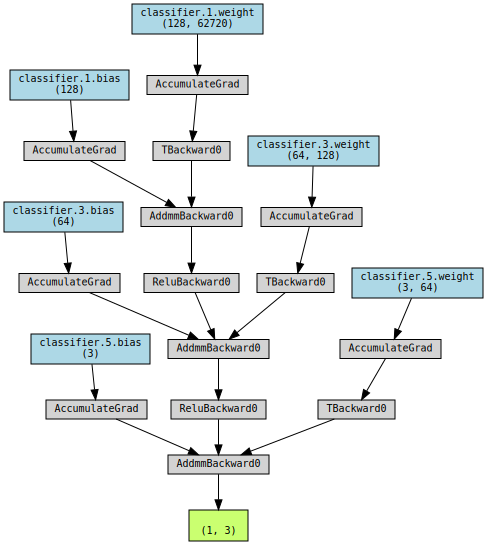

In [16]:
# Example input
example_input = torch.rand(1, 3, 224, 224).to(device)

# Forward pass
y = mobilenet_model(example_input)

# Visualize forward graph
torchviz.make_dot(y, params=dict(mobilenet_model.named_parameters()))

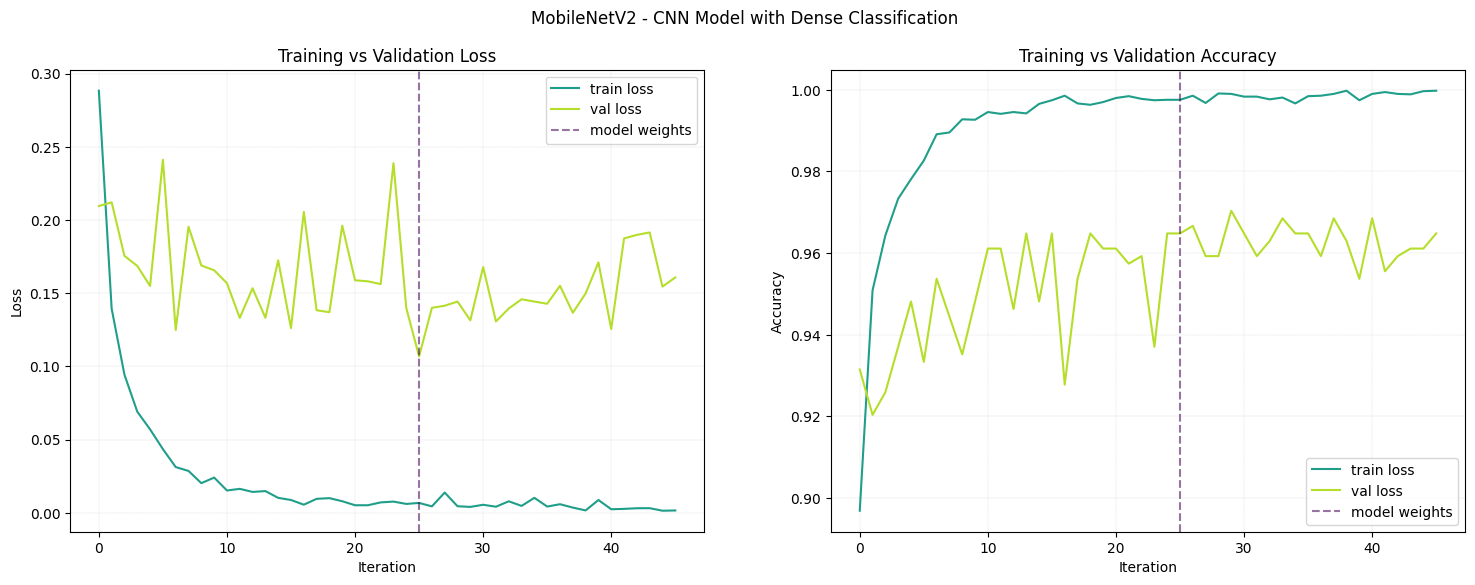

In [17]:
lowest = np.amin(results['test_loss'])
valloss_lowest = np.where(results['test_loss'] == lowest)

fig= plt.figure(figsize = (18, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results['train_loss'], color = '#1f9e89')
ax1.plot(results['test_loss'], color = '#b5de2b')
ax1.set_title('Training vs Validation Loss')
ax1.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax1.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results['train_acc'], color = '#1f9e89')
ax2.plot(results['test_acc'], color = '#b5de2b')
ax2.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax2.set_title('Training vs Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Iteration')
ax2.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax2.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='lower right')

plt.suptitle("MobileNetV2 - CNN Model with Dense Classification")
plt.show()

In [18]:
predictions = []
y_test = []
for i, (images, labels) in enumerate(test_loader):
    with torch.inference_mode():
        predictions.append(mobilenet_model(images.to(device)))
        y_test.append(labels)


predictions = torch.stack(predictions, dim = 0)
y_test = torch.stack(y_test, dim = 0)

In [19]:
y_pred = predictions.reshape(-1, 3)
y_test = y_test.reshape(-1)
y_pred= torch.argmax(y_pred, axis=1)

In [20]:
assert y_pred.shape == y_test.shape

In [21]:
print(classification_report(y_test.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       100
           1       0.90      0.96      0.93       100
           2       1.00      0.94      0.97       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [22]:
f1 = f1_score(y_test.cpu(), y_pred.cpu(), average='macro')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9505


In [23]:
cm = confusion_matrix(y_test.cpu(), y_pred.cpu())
class_labels = ["covid", "normal", "pneumonia"]

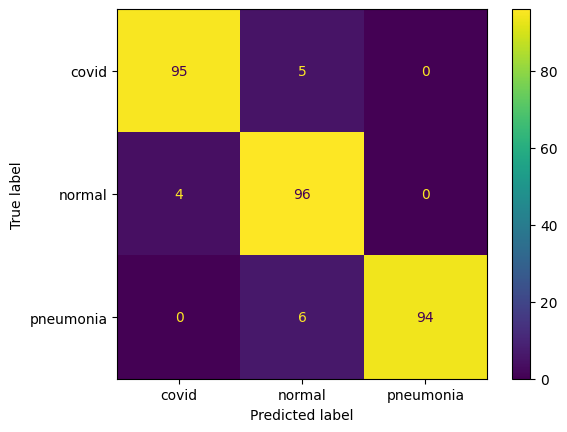

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.viridis)
plt.show()

In [25]:
metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
auc = metric(predictions.reshape(-1, 3).cpu(), y_test.cpu())
print(f'AUC: {auc:.4f}')

AUC: 0.9939


# 3. Explainable AI

In [26]:
import xai_modules.integrated_gradients as ig
import xai_modules.gradcam as gradcam

In [27]:
image = Image.open('data/test/covid/COVID-3542.png').convert('RGB')
exp_target = label_to_idx('covid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: 0
Expected Class: 0
Model confidence: 6.6342
Model sensitivity: 0.5103
Integrated_Grad sensitivity: 0.0000


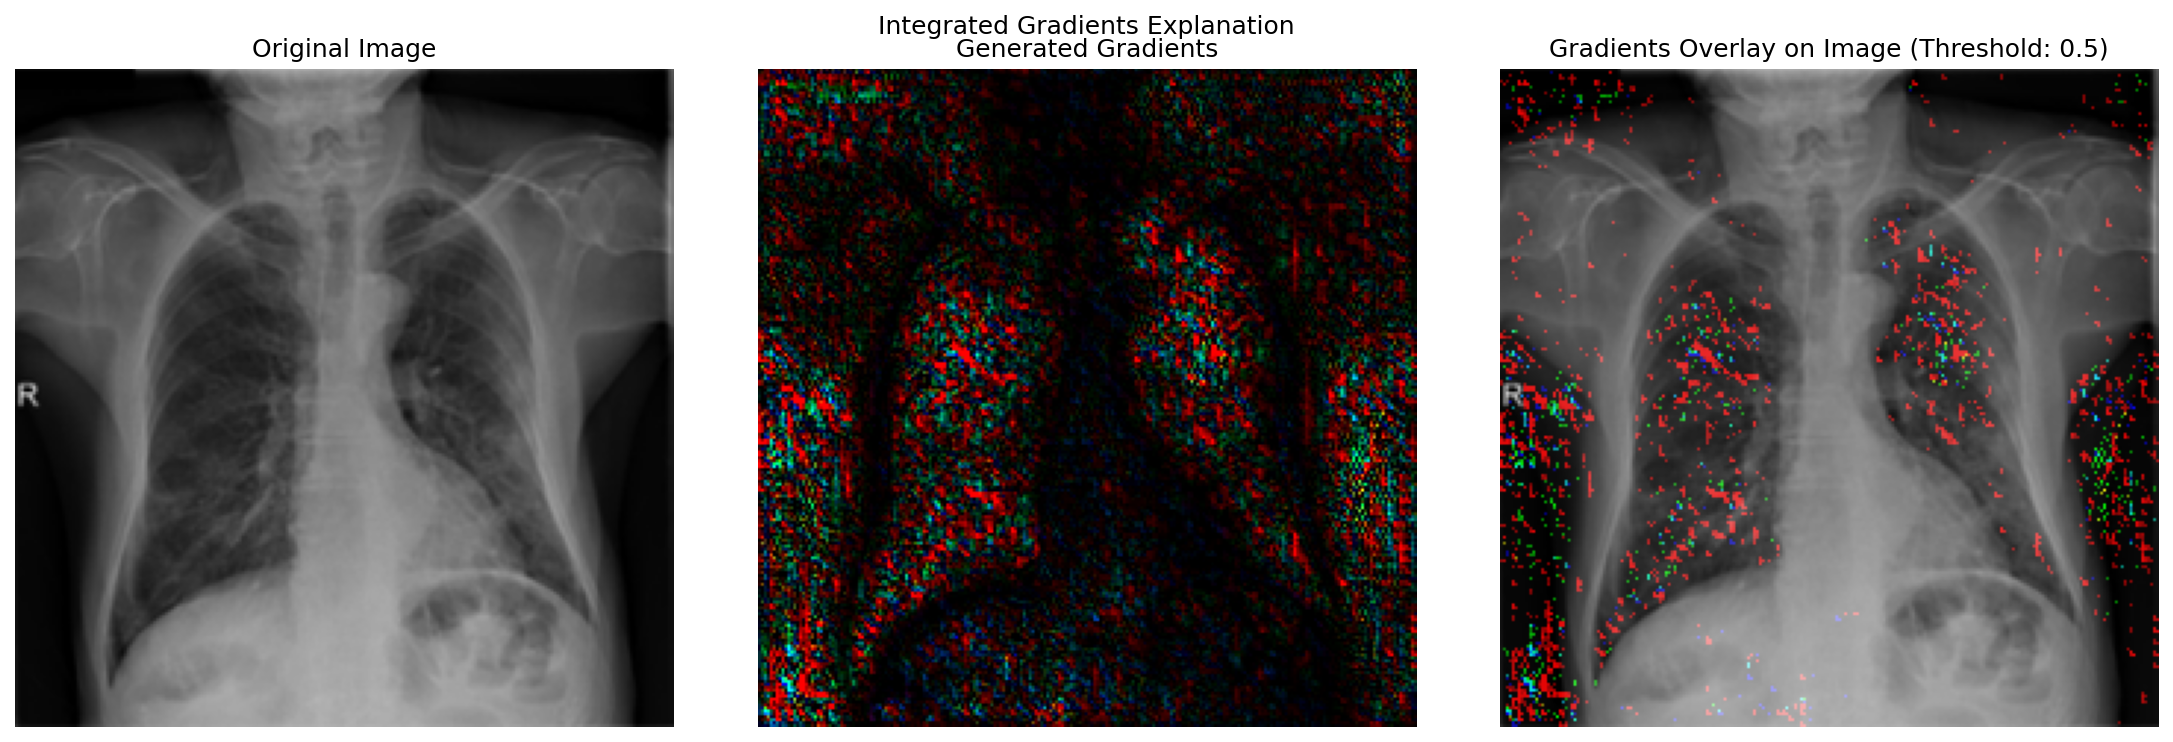

In [28]:
# Load model, image, etc
ig.visualize_integrated_grads(image, 
                            mobilenet_model, 
                            exp_target = exp_target,
                            ig_steps = 50,
                            grad_threshold = 0.5,
                            img_size = target_size, 
                            device = device)

In [29]:
# # Register hook to access last conv layer output
# features = mobilenet_model.features
# final_conv = features[-1]

# for m in final_conv.modules():
#   if isinstance(m, nn.Conv2d):
#     conv = m
#     break 
  
# activations = None

# def hook(model, input, output):
#     global activations
#     activations = output.detach()
# handle = final_conv.register_forward_hook(hook)

# transformed_img = transform1(image)
# input_img = normalize_tf(transformed_img).to(device).unsqueeze(0)

# for param in mobilenet_model.features.parameters():
#   param.requires_grad = True

# # Forward pass
# output = mobilenet_model(input_img) 

# # Remove hook
# handle.remove()

# # Get conv layer gradients
# pred_idx = output.argmax(dim=1).item()
# pred_class = idx_to_label(pred_idx)

# target_label = torch.Tensor(idx_to_onehot(target)).unsqueeze(0).to(device)

# # Compute loss
# loss = criterion(output, target_label) 
# loss.backward()


# grads = conv.weight.grad

# for param in mobilenet_model.features.parameters():
#   param.requires_grad = False

# # Generate heatmap
# weights = torch.mean(grads, dim=[1,2]) # Average gradient for each filter
# cam = torch.matmul(activations.reshape([7*7,1280]), weights)
# cam = cam.reshape(7, 7) # 7x7 activation map
# cam = cam - torch.min(cam)
# cam = cam / torch.max(cam) 
# heatmap = cv2.resize(cam.detach().cpu().numpy(), (224, 224))

# # Overlay heatmap on image
# img = transformed_img.detach().permute(1,2,0).cpu().numpy().squeeze()

# # Normalize the heatmap between 0 and 1
# heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# # Resize the heatmap to match the size of the original image
# heatmap = np.uint8(255 * heatmap)
# heatmap = Image.fromarray(heatmap).resize((img.shape[1], img.shape[0]))

# # Convert the heatmap to a numpy array
# heatmap = np.array(heatmap)

# # Apply a colormap to the normalized heatmap
# cmap = plt.cm.viridis
# heatmap = cmap(heatmap)


# # Display the result using matplotlib
# fig, axs = plt.subplots(1, 2, dpi = 150, figsize = (12, 5))
# axs[0].imshow(img)
# axs[0].set_title("Original Image")
# axs[0].axis('off')
# axs[1].imshow(img)
# axs[1].imshow(heatmap, alpha = 0.7)
# axs[1].set_title("Heatmap Overlay")
# axs[1].axis('off')

# # Add colorbar using the image without alpha
# colorbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axs[1], fraction=0.046, pad=0.04)
# colorbar.set_label('Activation Pixels Impact Regions')


# plt.tight_layout()
# plt.show()

Predicted Class: 0
Expected Class: 0
Model confidence: 6.6342
Model sensitivity: 0.5103


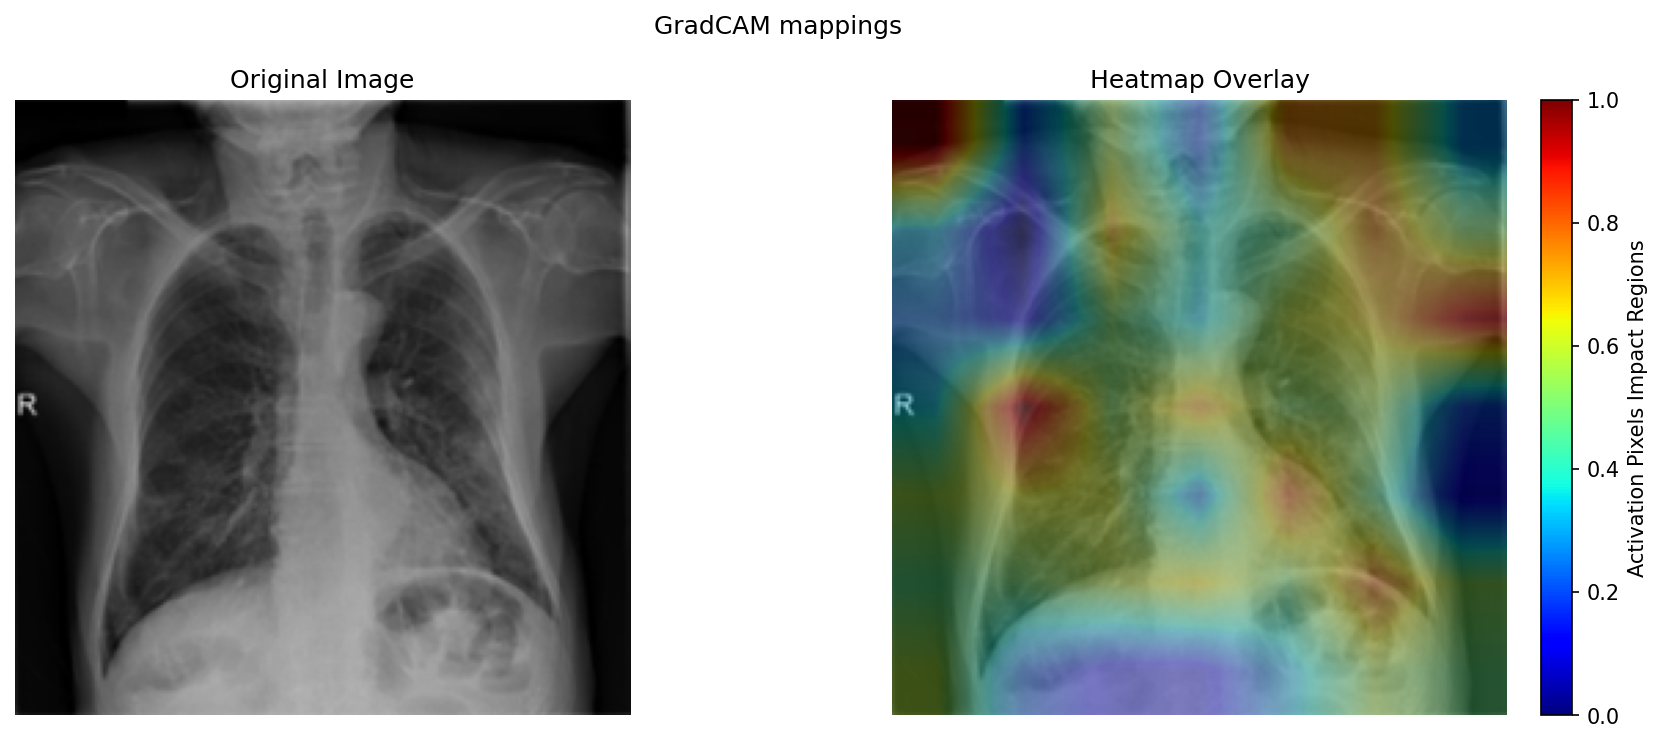

In [30]:
gradcam.visualize_gradcam(model = mobilenet_model,
                          model_type='CNN',
                          image = image,
                          exp_target = exp_target,
                          loss_fn = criterion,
                          final_layer = mobilenet_model.features[-1],
                          img_size = target_size,
                          device = device)